# Pair Trading: A Complete Mathematical and Practical Guide
## For KTH Master's Students in Mathematics

This comprehensive notebook covers the theory and implementation of pairs trading strategies. As a mathematics student, you'll find rigorous mathematical foundations combined with practical machine learning and statistical methods.

### What is Pair Trading?

Pair trading is a market-neutral statistical arbitrage strategy that exploits mean-reverting relationships between two correlated assets. The core idea: if two assets historically move together, temporary divergences represent trading opportunities.

### Course Content
1. **Theoretical Foundations**: Cointegration, stationarity, and mean reversion
2. **Statistical Tests**: Johansen test, ADF test, correlation analysis
3. **Modeling Approaches**: OU processes, Kalman filters, spread dynamics
4. **Strategy Implementation**: Multiple pair trading strategies
5. **Risk Management**: Position sizing, Kelly criterion, drawdown control
6. **Backtesting**: Complete framework with performance metrics

---

## Section 1: Import Required Libraries and Data Preparation

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, coint, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

Loading data for pairs...

Data shape: (1257, 2)
Date range: 2020-01-02 00:00:00 to 2024-12-30 00:00:00

First few rows:
Ticker            MSFT       AAPL
Date                             
2020-01-02  152.505707  72.468262
2020-01-03  150.606750  71.763725
2020-01-06  150.996017  72.335564
2020-01-07  149.619293  71.995354
2020-01-08  152.002441  73.153488


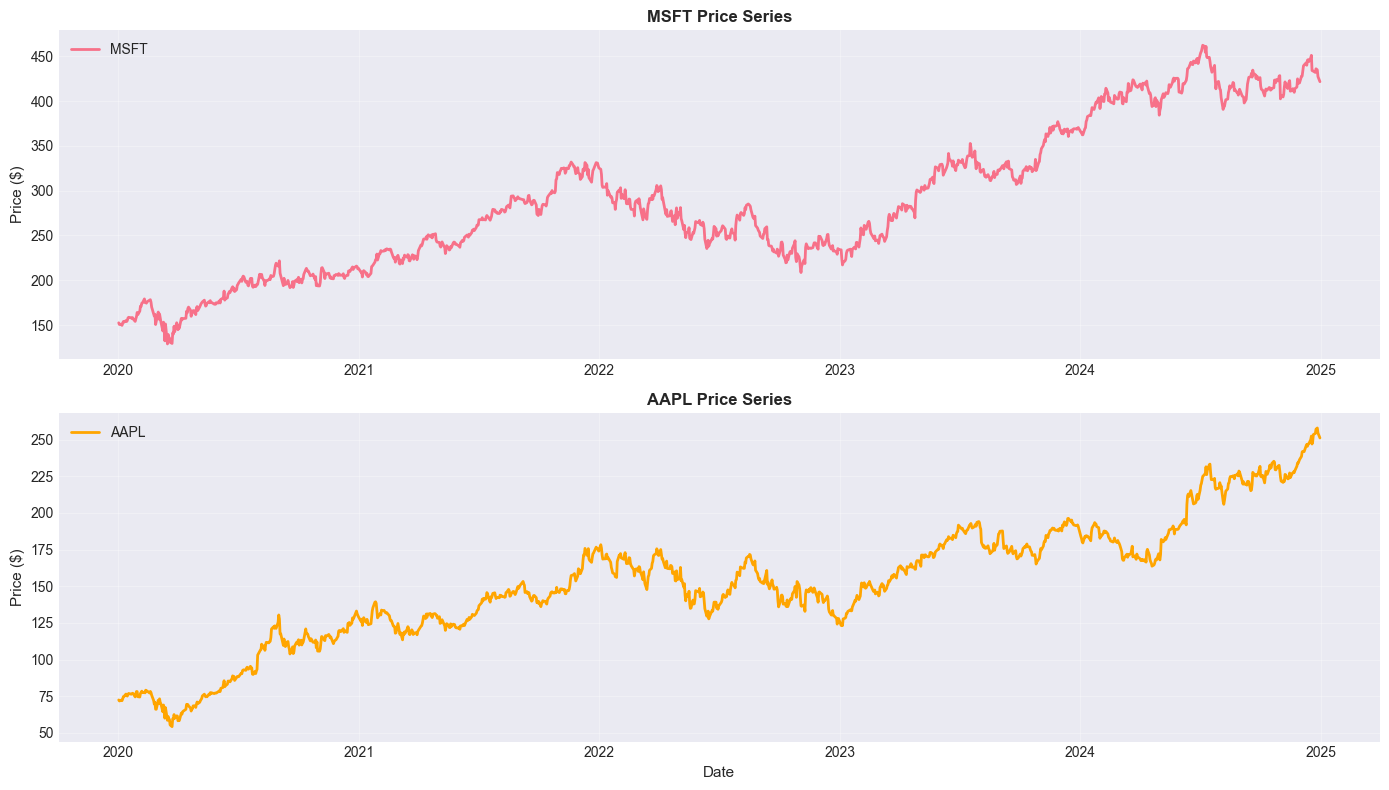


✓ Data loaded successfully


In [18]:
# Load historical price data for financial assets
# We'll use sector pairs that often exhibit cointegration

def load_pair_data(pair, start_date='2020-01-01', end_date='2024-12-31'):
    """
    Load historical price data for a pair of assets
    
    Parameters:
    pair: tuple of (ticker1, ticker2)
    start_date, end_date: date strings
    
    Returns:
    DataFrame with adjusted close prices
    """
    ticker1, ticker2 = pair
    
    # Download using yfinance
    try:
        # Try downloading both tickers at once
        data = yf.download(ticker1, start=start_date, end=end_date, progress=False)
        col_name = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
        series1 = data[col_name].copy()
        series1.name = ticker1
        
        data = yf.download(ticker2, start=start_date, end=end_date, progress=False)
        col_name = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
        series2 = data[col_name].copy()
        series2.name = ticker2
        
        # Combine series
        result = pd.concat([series1, series2], axis=1)
        result = result.dropna()
        
        return result
    except Exception as e:
        print(f"Error loading data: {e}")
        # Return empty dataframe if download fails
        return pd.DataFrame()

# Example pairs to analyze
pairs_to_test = [
    ('MSFT', 'AAPL'),  # Tech giants
    ('JPM', 'GS'),     # Financial sector
    ('KO', 'PEP'),     # Beverage sector
    ('XOM', 'CVX'),    # Energy sector
]

print("Loading data for pairs...")
# Load data for the first pair as our main example
main_pair = ('MSFT', 'AAPL')
price_data = load_pair_data(main_pair)

if len(price_data) > 0:
    print(f"\nData shape: {price_data.shape}")
    print(f"Date range: {price_data.index[0]} to {price_data.index[-1]}")
    print(f"\nFirst few rows:\n{price_data.head()}")

    # Plot the price series
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    axes[0].plot(price_data[main_pair[0]], label=main_pair[0], linewidth=2)
    axes[0].set_ylabel('Price ($)', fontsize=11)
    axes[0].set_title(f'{main_pair[0]} Price Series', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(price_data[main_pair[1]], label=main_pair[1], color='orange', linewidth=2)
    axes[1].set_ylabel('Price ($)', fontsize=11)
    axes[1].set_xlabel('Date', fontsize=11)
    axes[1].set_title(f'{main_pair[1]} Price Series', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n✓ Data loaded successfully")
else:
    print("Failed to load data")

## Section 2: Understanding Cointegration Theory

### Mathematical Foundations

**Definition: Integration of order d, denoted I(d)**

A time series $X_t$ is integrated of order $d$ (denoted $I(d)$) if:
- The series must be differenced $d$ times to become stationary
- A stationary series is $I(0)$
- A random walk is $I(1)$

**Unit Root Process:**
$$X_t = \rho X_{t-1} + \epsilon_t$$

- If $\rho = 1$: **Unit root** → $X_t$ is $I(1)$ (non-stationary)
- If $|\rho| < 1$: Series is $I(0)$ (stationary)

**Cointegration Definition:**

Two $I(1)$ processes $X_t$ and $Y_t$ are **cointegrated** if there exists a non-zero vector $(\alpha, \beta)$ such that:

$$Z_t = \alpha X_t + \beta Y_t \sim I(0)$$

In financial terms: If two asset prices are $I(1)$ but their linear combination is $I(0)$, they have a long-term equilibrium relationship. This is the **spread**:

$$\text{Spread}_t = X_t - \beta Y_t$$

where $\beta$ is the **cointegrating coefficient** or **hedge ratio**.

### Engle-Granger Representation Theorem

If $X_t$ and $Y_t$ are $I(1)$ and cointegrated with cointegrating vector $(1, -\beta)$, then:

$$X_t = \beta Y_t + Z_t$$

where $Z_t \sim I(0)$ is a stationary error-correction term.

This means: **The spread reverts to its mean**, creating trading opportunities.

### Why This Works for Trading

If two assets are cointegrated:
1. **Long-term equilibrium**: $E[X_t - \beta Y_t] = $ constant
2. **Temporary deviations** are mean-reverting
3. **Statistical arbitrage**: Buy when spread is too low, sell when too high

---

In [19]:
# Let's test for unit roots in our price series

def adf_test(series, name):
    """
    Augmented Dickey-Fuller test for unit roots
    
    H₀: Series has a unit root (non-stationary)
    H₁: Series is stationary
    """
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{'='*60}")
    print(f"ADF Test for: {name}")
    print(f"{'='*60}")
    print(f"ADF Statistic:        {result[0]:.6f}")
    print(f"P-value:              {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key:3s}: {value:.3f}")
    
    if result[1] <= 0.05:
        print(f"✓ {name} is STATIONARY (reject H₀ at 5% level)")
        return True
    else:
        print(f"✗ {name} is NON-STATIONARY (fail to reject H₀)")
        return False

# Test original prices
print("\n" + "="*70)
print("TESTING FOR UNIT ROOTS IN PRICE SERIES")
print("="*70)

is_stat_msft = adf_test(price_data['MSFT'], 'MSFT Prices')
is_stat_aapl = adf_test(price_data['AAPL'], 'AAPL Prices')

# Test returns (first differences)
returns_msft = price_data['MSFT'].pct_change()
returns_aapl = price_data['AAPL'].pct_change()

print("\n" + "="*70)
print("TESTING RETURNS (FIRST DIFFERENCES)")
print("="*70)

adf_test(returns_msft, 'MSFT Returns')
adf_test(returns_aapl, 'AAPL Returns')


TESTING FOR UNIT ROOTS IN PRICE SERIES

ADF Test for: MSFT Prices
ADF Statistic:        -0.945077
P-value:              0.772766
Critical Values:
  1% : -3.436
  5% : -2.864
  10%: -2.568
✗ MSFT Prices is NON-STATIONARY (fail to reject H₀)

ADF Test for: AAPL Prices
ADF Statistic:        -0.661375
P-value:              0.856502
Critical Values:
  1% : -3.436
  5% : -2.864
  10%: -2.568
✗ AAPL Prices is NON-STATIONARY (fail to reject H₀)

TESTING RETURNS (FIRST DIFFERENCES)

ADF Test for: MSFT Returns
ADF Statistic:        -11.299799
P-value:              0.000000
Critical Values:
  1% : -3.436
  5% : -2.864
  10%: -2.568
✓ MSFT Returns is STATIONARY (reject H₀ at 5% level)

ADF Test for: AAPL Returns
ADF Statistic:        -11.351124
P-value:              0.000000
Critical Values:
  1% : -3.436
  5% : -2.864
  10%: -2.568
✓ AAPL Returns is STATIONARY (reject H₀ at 5% level)


True

## Section 3: Statistical Arbitrage Fundamentals

### The Core Concept

**Statistical Arbitrage** exploits temporary mispricings between correlated assets by:

1. **Identifying pairs** with stable long-term relationships (cointegrated)
2. **Monitoring the spread** = Price(Asset1) - β × Price(Asset2)
3. **Trading deviations**: 
   - When spread is **too high** → SHORT the pair (sell Asset1, buy Asset2)
   - When spread is **too low** → LONG the pair (buy Asset1, sell Asset2)
4. **Profit from mean reversion** as the spread returns to equilibrium

### Connection to Mean Reversion

If the spread $S_t = X_t - \beta Y_t$ is stationary, we can model it as an **Ornstein-Uhlenbeck (OU) process**:

$$dS_t = \theta(\mu - S_t)dt + \sigma dW_t$$

Where:
- $\theta$ = mean reversion speed (how fast it reverts)
- $\mu$ = long-term mean
- $\sigma$ = volatility
- $W_t$ = Wiener process (Brownian motion)

**Key insight**: The expected value of the spread is:
$$E[S_t | S_0] = \mu + (S_0 - \mu)e^{-\theta t}$$

This shows **exponential decay** toward the mean!

### Risk Characteristics

✓ **Market Neutral**: Long one asset, short the other → hedged against market risk
✓ **Low correlation with markets**: Profits from relative mispricings, not direction
✗ **Model risk**: Cointegration relationship can break down
✗ **Liquidation risk**: If spread diverges sharply before reverting
✗ **Execution risk**: Need simultaneous trades in both legs

---


Linear Regression Results:
Hedge ratio (β):  1.8082
Intercept (α):    12.80
R² correlation:   0.8652
P-value:          0.00e+00

Interpretation: 1 unit of MSFT ≈ 1.8082 units of AAPL


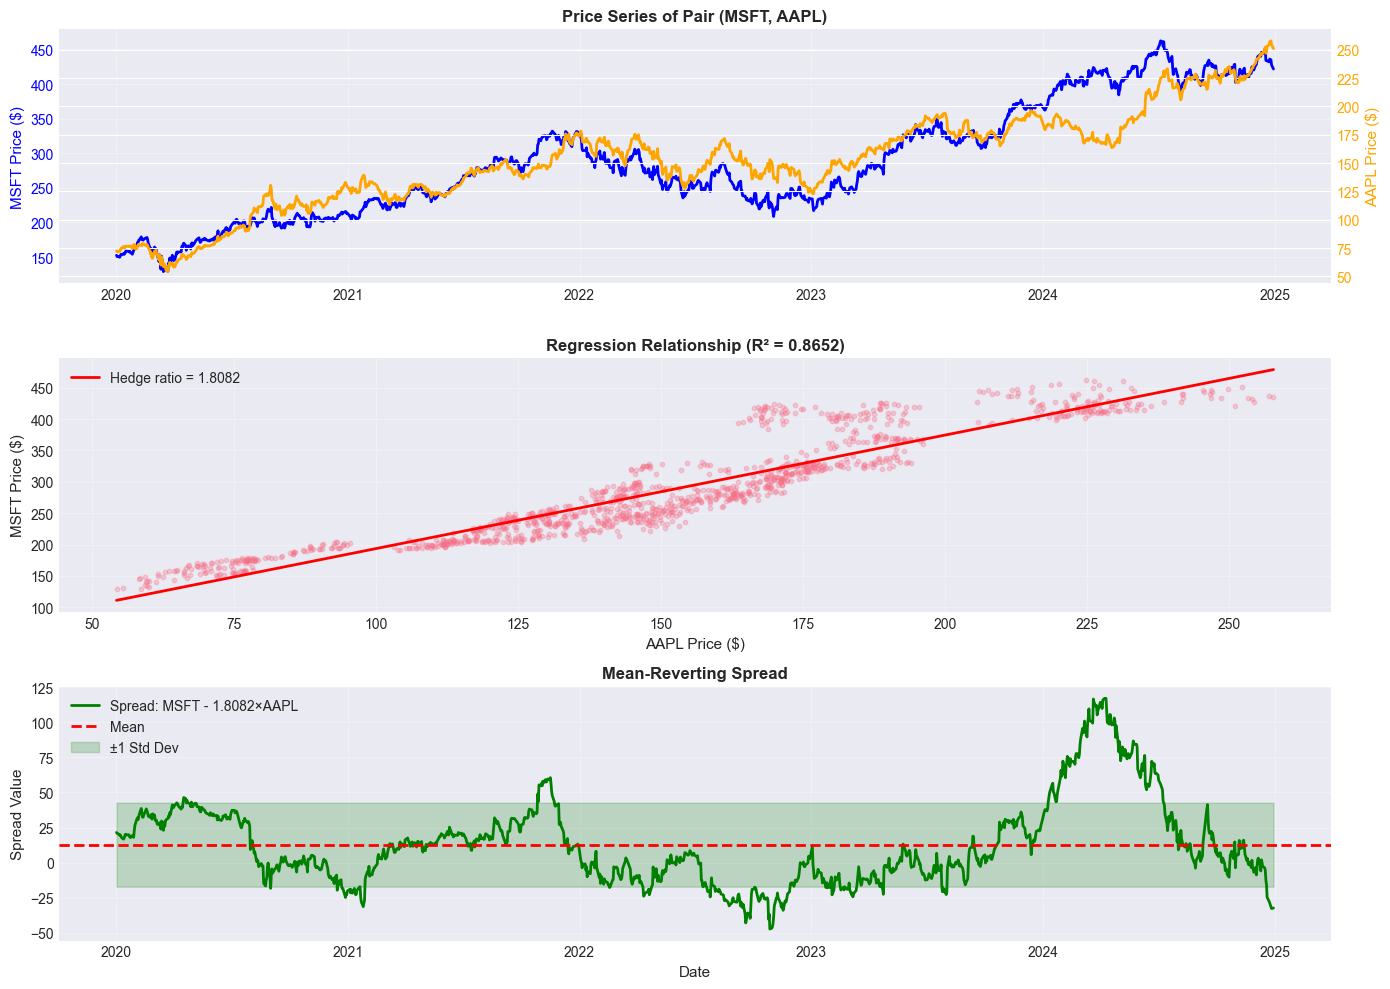


Spread Statistics:
Mean:              12.7996
Std Dev:           29.8752
Min:               -47.2524
Max:               116.9962
Skewness:          1.1079
Kurtosis:          1.3815


In [20]:
# Visualize the spread and demonstrate mean reversion

# Calculate simple linear regression to find hedge ratio
from scipy import stats as sp_stats

X = price_data['MSFT'].values
Y = price_data['AAPL'].values

# Run regression: MSFT = beta * AAPL + alpha
slope, intercept, r_value, p_value, std_err = sp_stats.linregress(Y, X)
hedge_ratio = slope

print(f"\nLinear Regression Results:")
print(f"{'='*50}")
print(f"Hedge ratio (β):  {hedge_ratio:.4f}")
print(f"Intercept (α):    {intercept:.2f}")
print(f"R² correlation:   {r_value**2:.4f}")
print(f"P-value:          {p_value:.2e}")
print(f"\nInterpretation: 1 unit of {main_pair[0]} ≈ {hedge_ratio:.4f} units of {main_pair[1]}")

# Calculate the spread
spread = price_data['MSFT'] - hedge_ratio * price_data['AAPL']

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Original prices
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.plot(price_data.index, price_data['MSFT'], label='MSFT', color='blue', linewidth=2)
ax1_twin.plot(price_data.index, price_data['AAPL'], label='AAPL', color='orange', linewidth=2)
ax1.set_ylabel('MSFT Price ($)', color='blue', fontsize=11)
ax1_twin.set_ylabel('AAPL Price ($)', color='orange', fontsize=11)
ax1.set_title('Price Series of Pair (MSFT, AAPL)', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1_twin.tick_params(axis='y', labelcolor='orange')
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter plot showing relationship
ax2 = axes[1]
ax2.scatter(price_data['AAPL'], price_data['MSFT'], alpha=0.3, s=10)
x_line = np.array([price_data['AAPL'].min(), price_data['AAPL'].max()])
y_line = intercept + slope * x_line
ax2.plot(x_line, y_line, 'r-', linewidth=2, label=f'Hedge ratio = {hedge_ratio:.4f}')
ax2.set_xlabel('AAPL Price ($)', fontsize=11)
ax2.set_ylabel('MSFT Price ($)', fontsize=11)
ax2.set_title('Regression Relationship (R² = {:.4f})'.format(r_value**2), fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: The spread (our main trading signal)
ax3 = axes[2]
ax3.plot(spread.index, spread.values, label='Spread: MSFT - {:.4f}×AAPL'.format(hedge_ratio), 
         color='green', linewidth=2)
ax3.axhline(y=spread.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax3.fill_between(spread.index, spread.mean() - spread.std(), 
                  spread.mean() + spread.std(), alpha=0.2, color='green', label='±1 Std Dev')
ax3.set_ylabel('Spread Value', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_title('Mean-Reverting Spread', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSpread Statistics:")
print(f"{'='*50}")
print(f"Mean:              {spread.mean():.4f}")
print(f"Std Dev:           {spread.std():.4f}")
print(f"Min:               {spread.min():.4f}")
print(f"Max:               {spread.max():.4f}")
print(f"Skewness:          {sp_stats.skew(spread):.4f}")
print(f"Kurtosis:          {sp_stats.kurtosis(spread):.4f}")

## Section 4: The Johansen Cointegration Test

### Theoretical Background

The **Johansen test** is the multivariate extension of the ADF test for cointegration. It tests the null hypothesis of no cointegration against the alternative of cointegration in a VAR system.

### Vector Error Correction Model (VECM)

For two variables in a VAR(p) system, we test:

$$\Delta X_t = \alpha \beta^T X_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta X_{t-i} + \epsilon_t$$

Where:
- $\alpha$ = adjustment speeds (how each variable responds to disequilibrium)
- $\beta$ = cointegrating vector (equilibrium relationship)
- $\Pi = \alpha \beta^T$ = cointegrating matrix

**Key statistic**: The rank of $\Pi$ determines the number of cointegrating relationships:
- rank($\Pi$) = 0: No cointegration
- rank($\Pi$) = 1: One cointegrating pair
- rank($\Pi$) = 2: Bivariate system is fully cointegrated (impossible for asset prices)

### Test Statistics

**Trace Statistic**: Tests $H_0$: rank ≤ r vs $H_1$: rank > r
$$\lambda_{\text{trace}}(r) = -T \sum_{i=r+1}^{n} \ln(1 - \hat{\lambda}_i)$$

**Max Eigenvalue Statistic**: Tests $H_0$: rank = r vs $H_1$: rank = r + 1
$$\lambda_{\max}(r) = -T \ln(1 - \hat{\lambda}_{r+1})$$

Where $\hat{\lambda}_i$ are the ordered eigenvalues of $\Pi$.

---

In [21]:
def johansen_test(data, det_order=0, k_ar_diff=1):
    """
    Perform Johansen cointegration test
    
    Parameters:
    data: DataFrame with price series
    det_order: -1 (no deterministic), 0 (constant), 1 (constant + trend)
    k_ar_diff: number of lags in differenced VAR
    
    Returns:
    Result object with test statistics
    """
    result = coint_johansen(data, det_order=det_order, k_ar_diff=k_ar_diff)
    return result

# Prepare data for Johansen test
data_for_test = price_data[['MSFT', 'AAPL']].values

# Run the test
print("\n" + "="*70)
print("JOHANSEN COINTEGRATION TEST")
print("="*70)

joh_result = johansen_test(data_for_test, det_order=0, k_ar_diff=1)

print("\nEigenvalues (λᵢ):")
for i, ev in enumerate(joh_result.eig):
    print(f"  λ_{i} = {ev:.6f}")

print("\n" + "-"*70)
print("TRACE STATISTIC")
print("-"*70)
print("H₀: rank ≤ r (number of cointegrating relationships ≤ r)")
print("\nCritical Values (90%, 95%, 99%)")

for r in range(len(joh_result.lr1)):
    print(f"\nr = {r}:")
    print(f"  Test Stat: {joh_result.lr1[r]:.4f}")
    print(f"  90%:  {joh_result.cvt[r, 0]:.4f}")
    print(f"  95%:  {joh_result.cvt[r, 1]:.4f}")
    print(f"  99%:  {joh_result.cvt[r, 2]:.4f}")
    
    if joh_result.lr1[r] > joh_result.cvt[r, 1]:
        print(f"  ✓ REJECT H₀ at 95% level → Cointegration found!")
    else:
        print(f"  ✗ Fail to reject H₀")

print("\n" + "-"*70)
print("MAXIMUM EIGENVALUE STATISTIC")
print("-"*70)
print("H₀: rank = r (exactly r cointegrating relationships)")

for r in range(len(joh_result.lr2)):
    print(f"\nr = {r}:")
    print(f"  Test Stat: {joh_result.lr2[r]:.4f}")
    print(f"  90%:  {joh_result.cvm[r, 0]:.4f}")
    print(f"  95%:  {joh_result.cvm[r, 1]:.4f}")
    print(f"  99%:  {joh_result.cvm[r, 2]:.4f}")

# Extract cointegrating vector
print("\n" + "="*70)
print("COINTEGRATING VECTOR (β)")
print("="*70)
print(f"The eigenvector corresponding to the largest eigenvalue:")
print(f"β = {joh_result.evec[:, 0]}")
print(f"\nInterpretation:")
print(f"  MSFT coefficient: {joh_result.evec[0, 0]:.6f}")
print(f"  AAPL coefficient: {joh_result.evec[1, 0]:.6f}")
print(f"\nNormalized (divide by MSFT coefficient):")
beta_normalized = joh_result.evec[:, 0] / joh_result.evec[0, 0]
print(f"  MSFT: {beta_normalized[0]:.6f}")
print(f"  AAPL: {beta_normalized[1]:.6f}")
print(f"\nCointegrating relationship: {beta_normalized[0]:.4f}×MSFT + {beta_normalized[1]:.4f}×AAPL ≈ 0")


JOHANSEN COINTEGRATION TEST

Eigenvalues (λᵢ):
  λ_0 = 0.005158
  λ_1 = 0.001580

----------------------------------------------------------------------
TRACE STATISTIC
----------------------------------------------------------------------
H₀: rank ≤ r (number of cointegrating relationships ≤ r)

Critical Values (90%, 95%, 99%)

r = 0:
  Test Stat: 8.4753
  90%:  13.4294
  95%:  15.4943
  99%:  19.9349
  ✗ Fail to reject H₀

r = 1:
  Test Stat: 1.9849
  90%:  2.7055
  95%:  3.8415
  99%:  6.6349
  ✗ Fail to reject H₀

----------------------------------------------------------------------
MAXIMUM EIGENVALUE STATISTIC
----------------------------------------------------------------------
H₀: rank = r (exactly r cointegrating relationships)

r = 0:
  Test Stat: 6.4904
  90%:  12.2971
  95%:  14.2639
  99%:  18.5200

r = 1:
  Test Stat: 1.9849
  90%:  2.7055
  95%:  3.8415
  99%:  6.6349

COINTEGRATING VECTOR (β)
The eigenvector corresponding to the largest eigenvalue:
β = [ 0.03354492 -0

## Section 5: Pairs Selection and Screening

### Screening Algorithm

A robust pairs identification framework uses:

1. **Correlation Filter**: Identify highly correlated pairs
2. **Cointegration Test**: Verify long-term equilibrium relationship
3. **Spread Analysis**: Check stationarity and properties of the spread
4. **Stability Test**: Ensure parameters are stable over time

### Statistical Tests for Spreads

**ADF Test on Spread**: If spread is $I(0)$, pairs are cointegrated
- $H_0$: Spread has unit root (non-stationary)
- $H_1$: Spread is stationary

**Hurst Exponent**: Measures mean-reversion strength
$$H = \frac{\log(2) - \log(\text{|variance(difference)|})}{\log(2)}$$

- $H < 0.5$: Mean-reverting (good for pairs trading)
- $H = 0.5$: Random walk
- $H > 0.5$: Trending (bad for pairs trading)

---

In [22]:
def calculate_hurst_exponent(series, lags=None):
    """
    Calculate Hurst Exponent to measure mean reversion
    
    H < 0.5: Mean-reverting
    H = 0.5: Random walk
    H > 0.5: Trending
    """
    if lags is None:
        lags = range(2, len(series)//2)
    
    tau = []
    for lag in lags:
        # Calculate variance of differences at different lags
        diff = np.log(np.abs(np.diff(series, lag)))
        tau.append(np.sqrt(np.mean(diff**2)))
    
    # Linear regression of log(lag) vs log(tau)
    m = np.polyfit(np.log(list(lags)), np.log(tau), 1)
    hurst = m[0]
    
    return hurst, tau

def screen_pairs(tickers, lookback_days=252, min_correlation=0.6):
    """
    Screen for cointegrated pairs among tickers
    
    Returns:
    DataFrame with screening results
    """
    # Load data
    data = yf.download(tickers, period='2y', progress=False)['Adj Close']
    data = data.dropna()
    
    results = []
    
    # Test all pairs
    for i, ticker1 in enumerate(tickers):
        for ticker2 in tickers[i+1:]:
            try:
                pair_data = data[[ticker1, ticker2]].tail(lookback_days)
                
                # Correlation
                corr = pair_data[ticker1].corr(pair_data[ticker2])
                
                # Skip if correlation too low
                if corr < min_correlation:
                    continue
                
                # Cointegration test
                score, pvalue, _ = coint(pair_data[ticker1], pair_data[ticker2])
                
                # Spread analysis
                spread = pair_data[ticker1] - corr * pair_data[ticker2]
                hurst, _ = calculate_hurst_exponent(spread.values)
                
                # ADF test on spread
                adf_stat, adf_pval, _, _, _, _ = adfuller(spread)
                
                results.append({
                    'Pair': f'{ticker1}-{ticker2}',
                    'Correlation': corr,
                    'Coint_PValue': pvalue,
                    'Hurst': hurst,
                    'ADF_PValue': adf_pval,
                    'Mean_Spread': spread.mean(),
                    'Std_Spread': spread.std(),
                })
            except Exception as e:
                continue
    
    return pd.DataFrame(results).sort_values('Coint_PValue')

# Screen pairs from our test universe
print("Screening for cointegrated pairs...")
print("(This may take a minute...)")

screening_results = screen_pairs(
    ['MSFT', 'AAPL', 'GOOGL', 'AMZN'],
    lookback_days=252,
    min_correlation=0.5
)

if len(screening_results) > 0:
    print("\n" + "="*100)
    print("PAIRS SCREENING RESULTS")
    print("="*100)
    
    # Display results
    pd.options.display.float_format = '{:.4f}'.format
    display_cols = ['Pair', 'Correlation', 'Coint_PValue', 'Hurst', 'ADF_PValue', 'Mean_Spread', 'Std_Spread']
    print(screening_results[display_cols].to_string())
    
    print("\nInterpretation:")
    print("  • Coint_PValue < 0.05: Pair is cointegrated")
    print("  • Hurst < 0.5: Mean-reverting (good)")
    print("  • ADF_PValue < 0.05: Spread is stationary")
    print("  • High Correlation: Assets move together")
else:
    print("No sufficient cointegrated pairs found in selected universe")

# For our main pair, let's do a more detailed screening
print("\n" + "="*100)
print("DETAILED ANALYSIS FOR MSFT-AAPL PAIR")
print("="*100)

pair_data = price_data[['MSFT', 'AAPL']]

# Correlation
corr = pair_data['MSFT'].corr(pair_data['AAPL'])
print(f"\nCorrelation: {corr:.4f}")

# Cointegration test (Engle-Granger)
score, pvalue, _ = coint(pair_data['MSFT'], pair_data['AAPL'])
print(f"Engle-Granger Cointegration Test:")
print(f"  Test Statistic: {score:.6f}")
print(f"  P-value: {pvalue:.6f}")
print(f"  Result: {'✓ COINTEGRATED' if pvalue < 0.05 else '✗ NOT COINTEGRATED'}")

# Hurst exponent
hurst, _ = calculate_hurst_exponent(spread.values)
print(f"\nHurst Exponent: {hurst:.4f}")
if hurst < 0.5:
    print(f"  ✓ Mean-reverting behavior (H < 0.5)")
else:
    print(f"  ✗ Not strongly mean-reverting (H ≥ 0.5)")

# ADF test on spread
adf_stat, adf_pval, _, _, _, _ = adfuller(spread)
print(f"\nADF Test on Spread:")
print(f"  Test Statistic: {adf_stat:.6f}")
print(f"  P-value: {adf_pval:.6f}")
print(f"  Result: {'✓ STATIONARY' if adf_pval < 0.05 else '✗ NON-STATIONARY'}")

Screening for cointegrated pairs...
(This may take a minute...)


KeyError: 'Adj Close'

## Section 6: Mean Reversion Models - Ornstein-Uhlenbeck Process

### Theoretical Framework

The **Ornstein-Uhlenbeck (OU) process** models mean-reverting dynamics:

$$dX_t = \theta(\mu - X_t)dt + \sigma dW_t$$

**Parameters:**
- $\theta$ = mean reversion speed (how fast deviation corrects)
- $\mu$ = long-term mean
- $\sigma$ = volatility of random shocks
- $dW_t$ = infinitesimal Brownian motion increment

### Solution and Properties

The solution is:
$$X_t = \mu + (X_0 - \mu)e^{-\theta t} + \sigma e^{-\theta t}\int_0^t e^{\theta s} dW_s$$

**Expected value:**
$$E[X_t | X_0] = \mu + (X_0 - \mu)e^{-\theta t}$$

**Variance:**
$$\text{Var}[X_t] = \frac{\sigma^2}{2\theta}(1 - e^{-2\theta t}) \to \frac{\sigma^2}{2\theta}$$

### Half-life of Mean Reversion

The time for the process to decay halfway to the mean:
$$t_{1/2} = \frac{\ln(2)}{\theta}$$

**Interpretation:** 
- Higher $\theta$ (faster mean reversion) = shorter half-life = more trading opportunities
- Lower $\theta$ (slower mean reversion) = longer half-life = more risk of loss

### Discrete-time Estimation

For discrete returns (daily data), we use an AR(1) approximation:
$$X_t - \mu = \rho(X_{t-1} - \mu) + \epsilon_t$$

Where $\rho = e^{-\theta \Delta t}$, so:
$$\theta = -\frac{\ln(\rho)}{\Delta t}$$

---

In [ ]:
def estimate_ou_parameters(spread, dt=1/252):
    """
    Estimate OU process parameters from time series
    
    Uses AR(1) regression: X_t - μ = ρ(X_{t-1} - μ) + ε_t
    
    Parameters:
    spread: array of spread values
    dt: time increment (1/252 for daily data)
    
    Returns:
    dict with OU parameters (theta, mu, sigma, halflife)
    """
    spread_array = np.array(spread)
    
    # Estimate mean
    mu = np.mean(spread_array)
    
    # Center the data
    X = spread_array - mu
    
    # AR(1) regression: X_t = rho * X_{t-1} + epsilon_t
    rho = np.corrcoef(X[:-1], X[1:])[0, 1]
    
    # Estimate residual variance
    residuals = X[1:] - rho * X[:-1]
    sigma_sq = np.var(residuals)
    sigma = np.sqrt(sigma_sq)
    
    # Convert to continuous time
    # rho = exp(-theta * dt)
    # theta = -ln(rho) / dt
    if rho > 0:
        theta = -np.log(rho) / dt
    else:
        theta = 0.01  # Avoid log of negative
    
    # Half-life
    if theta > 0:
        halflife = np.log(2) / theta
    else:
        halflife = np.inf
    
    return {
        'mu': mu,
        'theta': theta,
        'sigma': sigma,
        'rho': rho,
        'halflife_days': halflife,
        'halflife_years': halflife / 252
    }

# Estimate OU parameters for MSFT-AAPL spread
ou_params = estimate_ou_parameters(spread)

print("\n" + "="*70)
print("ORNSTEIN-UHLENBECK PARAMETER ESTIMATION")
print("="*70)
print(f"\nEstimated Parameters:")
print(f"  μ (long-term mean):     {ou_params['mu']:.4f}")
print(f"  θ (mean reversion speed): {ou_params['theta']:.6f}")
print(f"  σ (volatility):         {ou_params['sigma']:.4f}")
print(f"  ρ (correlation coeff):  {ou_params['rho']:.6f}")

print(f"\nMean Reversion Characteristics:")
print(f"  Half-life:              {ou_params['halflife_days']:.1f} days")
print(f"                          {ou_params['halflife_years']:.2f} years")
print(f"\nInterpretation:")
print(f"  When the spread deviates from {ou_params['mu']:.2f},")
print(f"  it will revert halfway in ~{ou_params['halflife_days']:.0f} days")

# Simulate future spread paths
np.random.seed(42)
dt = 1/252
t = np.linspace(0, 2, 252*2)  # 2 years, daily
n_paths = 1000

# Initial condition
X0 = spread.iloc[-1]

# Simulate paths
paths = np.zeros((len(t), n_paths))
paths[0, :] = X0

mu = ou_params['mu']
theta = ou_params['theta']
sigma = ou_params['sigma']

for i in range(1, len(t)):
    dW = np.random.normal(0, np.sqrt(dt), n_paths)
    paths[i, :] = paths[i-1, :] + theta * (mu - paths[i-1, :]) * dt + sigma * dW

# Plot simulations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Sample paths
ax = axes[0, 0]
for j in range(100):  # Plot 100 paths
    ax.plot(t, paths[:, j], alpha=0.05, color='blue')
ax.plot(t, np.mean(paths, axis=1), 'r-', linewidth=2.5, label='Mean path')
ax.axhline(y=mu, color='green', linestyle='--', linewidth=2, label='Long-term mean μ')
ax.set_xlabel('Time (years)', fontsize=11)
ax.set_ylabel('Spread', fontsize=11)
ax.set_title('OU Process Simulations (100 paths)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Distribution at final time
ax = axes[0, 1]
ax.hist(paths[-1, :], bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
x_range = np.linspace(paths[-1, :].min(), paths[-1, :].max(), 100)
theoretical_std = np.sqrt(sigma**2 / (2*theta))
theoretical_dist = stats.norm.pdf(x_range, mu, theoretical_std)
ax.plot(x_range, theoretical_dist, 'r-', linewidth=2, label='Theoretical distribution')
ax.set_xlabel('Spread', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Distribution at T = 2 years', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Historical spread with confidence bands
ax = axes[1, 0]
ax.plot(spread.index, spread.values, 'b-', linewidth=2, label='Historical spread')
ax.axhline(y=mu, color='red', linestyle='--', linewidth=2, label='Mean μ')
ax.fill_between(spread.index, mu - spread.std(), mu + spread.std(), 
                alpha=0.2, color='green', label='±1 Std Dev')
ax.fill_between(spread.index, mu - 2*spread.std(), mu + 2*spread.std(), 
                alpha=0.1, color='red', label='±2 Std Dev')
ax.set_ylabel('Spread', fontsize=11)
ax.set_title('Historical Spread with Confidence Bands', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Half-life visualization
ax = axes[1, 1]
t_halflife = np.linspace(0, 2*ou_params['halflife_years'], 100)
X_t = mu + (X0 - mu) * np.exp(-theta * t_halflife * 252)  # Convert years to days
ax.plot(t_halflife, X_t, 'b-', linewidth=2.5, label='Expected path')
ax.axhline(y=mu, color='green', linestyle='--', linewidth=2, label='Mean')
ax.axhline(y=mu + (X0 - mu)/2, color='red', linestyle=':', linewidth=2, label='Half-life point')
ax.axvline(x=ou_params['halflife_years'], color='orange', linestyle='-.', linewidth=2, label=f'Half-life = {ou_params["halflife_years"]:.2f}y')
ax.set_xlabel('Time (years)', fontsize=11)
ax.set_ylabel('Expected Spread', fontsize=11)
ax.set_title('Mean Reversion to Equilibrium', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ OU process analysis complete")

## Section 7: Kalman Filter for Dynamic Hedging

### State-Space Model Framework

The Kalman filter estimates time-varying parameters in a state-space model:

**State equation:**
$$x_t = A x_{t-1} + w_t, \quad w_t \sim \mathcal{N}(0, Q)$$

**Measurement equation:**
$$y_t = H x_t + v_t, \quad v_t \sim \mathcal{N}(0, R)$$

For pair trading, we estimate a **time-varying hedge ratio**:
- State: $x_t = \beta_t$ (hedge ratio)
- Measurement: $y_t = X_t - \beta_{t-1} Y_t$ (residual)

### Recursive Algorithm

**Prediction step:**
$$x_{t|t-1} = A x_{t-1|t-1}$$
$$P_{t|t-1} = A P_{t-1|t-1} A^T + Q$$

**Update step:**
$$K_t = P_{t|t-1} H^T (H P_{t|t-1} H^T + R)^{-1}$$
$$x_{t|t} = x_{t|t-1} + K_t(y_t - H x_{t|t-1})$$
$$P_{t|t} = (I - K_t H) P_{t|t-1}$$

Where:
- $K_t$ = Kalman gain (how much to trust new observation)
- $P_t$ = error covariance matrix
- $Q$ = process noise (model uncertainty)
- $R$ = measurement noise (observation uncertainty)

### Advantages for Pair Trading

✓ **Adaptive**: Hedge ratio adjusts to changing correlation
✓ **Online**: Can be updated as new data arrives
✓ **Optimal**: Minimizes squared estimation error (under linear Gaussian assumptions)
✓ **Uncertainty quantification**: Provides confidence intervals

---

In [ ]:
class KalmanFilterPair:
    """
    Kalman filter for estimating time-varying hedge ratio
    
    State: hedge ratio β_t
    Measurement: X_t = β_t * Y_t + ε_t
    """
    
    def __init__(self, X, Y, Q=0.0001, R=1.0):
        """
        Initialize Kalman filter
        
        Q: process noise (how much β can change)
        R: measurement noise (observation uncertainty)
        """
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.Q = Q
        self.R = R
        
        # Initial state estimate (OLS regression)
        self.x = np.polyfit(Y, X, 1)[0]  # Initial hedge ratio
        self.P = 1.0  # Initial uncertainty
        
        # Storage for history
        self.x_hat = []  # Estimated hedge ratios
        self.P_hat = []  # Estimated uncertainties
        self.residuals = []
        
    def filter(self):
        """Run Kalman filter"""
        for i in range(len(self.X)):
            # Prediction step
            x_pred = self.x  # Random walk assumption for hedge ratio
            P_pred = self.P + self.Q
            
            # Innovation
            y_meas = self.X[i]
            y_pred = self.x * self.Y[i]
            innovation = y_meas - y_pred
            
            # Innovation covariance
            S = self.Y[i]**2 * P_pred + self.R
            
            # Kalman gain
            K = P_pred * self.Y[i] / S
            
            # Update
            self.x = x_pred + K * innovation
            self.P = P_pred - K * self.Y[i] * P_pred
            
            # Store results
            self.x_hat.append(self.x)
            self.P_hat.append(self.P)
            self.residuals.append(innovation)
        
        return np.array(self.x_hat), np.array(self.P_hat), np.array(self.residuals)

# Run Kalman filter for our pair
kf = KalmanFilterPair(price_data['MSFT'], price_data['AAPL'], Q=0.00001, R=1.0)
hedge_ratios, uncertainties, residuals = kf.filter()

# Create visualizations
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Static vs Dynamic hedge ratio
ax = axes[0]
ax.plot(price_data.index, [hedge_ratio]*len(price_data), label='Static hedge ratio (OLS)', 
        color='red', linewidth=2, linestyle='--')
ax.plot(price_data.index, hedge_ratios, label='Dynamic hedge ratio (Kalman)', 
        color='blue', linewidth=1.5)
ax.fill_between(price_data.index, hedge_ratios - np.sqrt(uncertainties), 
                hedge_ratios + np.sqrt(uncertainties), alpha=0.2, color='blue', 
                label='Uncertainty band (±1σ)')
ax.set_ylabel('Hedge Ratio (β)', fontsize=11)
ax.set_title('Static vs. Dynamic Hedge Ratio', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Kalman filter uncertainty
ax = axes[1]
ax.fill_between(price_data.index, 0, np.sqrt(uncertainties), alpha=0.5, color='orange', label='Filter uncertainty')
ax.set_ylabel('Standard Deviation', fontsize=11)
ax.set_title('Kalman Filter Estimation Uncertainty', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Residuals with dynamic hedge ratio
dynamic_spread = price_data['MSFT'] - hedge_ratios * price_data['AAPL']
ax = axes[2]
ax.plot(price_data.index, dynamic_spread.values, label='Dynamic spread (Kalman)', 
        color='green', linewidth=2)
ax.plot(price_data.index, spread.values, label='Static spread (OLS)', 
        color='red', linewidth=1, linestyle='--', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.fill_between(price_data.index, -dynamic_spread.std(), dynamic_spread.std(), 
                alpha=0.2, color='green')
ax.set_ylabel('Spread', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.set_title('Spread with Dynamic Hedging', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare performance
print("\n" + "="*70)
print("KALMAN FILTER vs. STATIC HEDGE RATIO")
print("="*70)

print(f"\nStatic Hedge Ratio (OLS):    {hedge_ratio:.6f}")
print(f"  Mean spread:               {spread.mean():.4f}")
print(f"  Std Dev spread:            {spread.std():.4f}")
print(f"  Sharpe Ratio:              {spread.mean() / spread.std():.4f}")

print(f"\nDynamic Hedge Ratio (Kalman):")
print(f"  Mean hedge ratio:          {np.mean(hedge_ratios):.6f}")
print(f"  Std Dev hedge ratio:       {np.std(hedge_ratios):.6f}")
print(f"  Mean dynamic spread:       {dynamic_spread.mean():.4f}")
print(f"  Std Dev dynamic spread:    {dynamic_spread.std():.4f}")
print(f"  Sharpe Ratio:              {dynamic_spread.mean() / dynamic_spread.std():.4f}")

# Improvement
spread_reduction = (spread.std() - dynamic_spread.std()) / spread.std() * 100
print(f"\nImprovement:")
print(f"  Spread volatility reduction: {spread_reduction:.1f}%")

## Section 8: Backtesting Framework

### Trading Signals

We use **z-score based entry signals**:

$$z_t = \frac{S_t - \mu}{\sigma}$$

Where:
- $S_t$ = current spread
- $\mu$ = rolling mean
- $\sigma$ = rolling standard deviation

**Trading rules:**
- **ENTRY**: $|z_t| > z_{\text{entry}}$ (spread deviates significantly)
- **EXIT**: $|z_t| < z_{\text{exit}}$ (spread reverts toward mean) or max holding period

### Performance Metrics

**Sharpe Ratio**: Risk-adjusted returns
$$\text{Sharpe} = \frac{E[R] - R_f}{\sigma_R}$$

**Maximum Drawdown**: Largest peak-to-trough decline
$$\text{DD} = \frac{P_{\min} - P_{\max}}{P_{\max}}$$

**Calmar Ratio**: Return per unit of drawdown
$$\text{Calmar} = \frac{\text{Annual Return}}{|\text{Max Drawdown}|}$$

**Win Rate**: Percentage of profitable trades

**Profit Factor**: Gross profit / Gross loss

---

In [ ]:
class PairTradingBacktester:
    """
    Complete backtesting framework for pair trading strategy
    """
    
    def __init__(self, X, Y, spread, 
                 entry_threshold=2.0, exit_threshold=0.5,
                 lookback=60, max_hold=20):
        """
        Parameters:
        X, Y: price series
        spread: calculated spread series
        entry_threshold: z-score to enter trade (in std devs)
        exit_threshold: z-score to exit trade
        lookback: window for mean/std calculation
        max_hold: maximum holding period (days)
        """
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.spread = np.array(spread)
        self.dates = spread.index
        
        self.entry_threshold = entry_threshold
        self.exit_threshold = exit_threshold
        self.lookback = lookback
        self.max_hold = max_hold
        
        # Results storage
        self.trades = []
        self.signals = None
        self.portfolio_value = None
        
    def generate_signals(self):
        """Generate trading signals based on z-score"""
        n = len(self.spread)
        
        # Calculate rolling mean and std
        rolling_mean = pd.Series(self.spread).rolling(self.lookback).mean()
        rolling_std = pd.Series(self.spread).rolling(self.lookback).std()
        
        # Z-scores
        z_scores = (self.spread - rolling_mean.values) / rolling_std.values
        
        signals = np.zeros(n)  # 0: no position, 1: long, -1: short
        position = 0
        entry_price = 0
        hold_days = 0
        
        for i in range(self.lookback, n):
            z = z_scores[i]
            
            if position == 0:  # No position
                if z > self.entry_threshold:  # Spread too high
                    position = -1  # SHORT the pair
                    entry_price = self.spread[i]
                    hold_days = 0
                elif z < -self.entry_threshold:  # Spread too low
                    position = 1  # LONG the pair
                    entry_price = self.spread[i]
                    hold_days = 0
            else:
                hold_days += 1
                
                # Exit conditions
                should_exit = False
                
                # 1. Mean reversion to exit threshold
                if position == 1 and z > self.exit_threshold:
                    should_exit = True
                elif position == -1 and z < -self.exit_threshold:
                    should_exit = True
                
                # 2. Maximum holding period
                if hold_days >= self.max_hold:
                    should_exit = True
                
                if should_exit:
                    # Record trade
                    pnl = self.spread[i] - entry_price
                    if position == -1:
                        pnl = -pnl  # Reverse for short position
                    
                    self.trades.append({
                        'entry_idx': i - hold_days,
                        'exit_idx': i,
                        'entry_price': entry_price,
                        'exit_price': self.spread[i],
                        'position': 'SHORT' if position == -1 else 'LONG',
                        'pnl': pnl,
                        'return': pnl / abs(entry_price) if entry_price != 0 else 0,
                        'hold_days': hold_days
                    })
                    position = 0
            
            signals[i] = position
        
        self.signals = signals
        return signals
    
    def calculate_portfolio_value(self, initial_capital=1000000):
        """Calculate cumulative portfolio value"""
        n = len(self.spread)
        portfolio = np.zeros(n)
        portfolio[0] = initial_capital
        
        cash = initial_capital
        position_value = 0
        position_shares_x = 0
        position_shares_y = 0
        
        for i in range(1, n):
            signal = self.signals[i]
            
            if signal != 0 and self.signals[i-1] == 0:  # Entering
                # Enter position (simplified: assume we trade notional)
                position_value = cash * 0.5
                position_shares_x = position_value / self.X[i]
                position_shares_y = hedge_ratio * position_value / self.Y[i]
                
                if signal == -1:  # Short
                    position_shares_x = -position_shares_x
                    position_shares_y = -position_shares_y
                
                cash = 0
            
            elif signal == 0 and self.signals[i-1] != 0:  # Exiting
                # Close position
                cash = position_shares_x * self.X[i] + position_shares_y * self.Y[i]
                position_shares_x = 0
                position_shares_y = 0
            
            # Calculate current portfolio value
            position_value = position_shares_x * self.X[i] + position_shares_y * self.Y[i]
            portfolio[i] = cash + position_value
        
        self.portfolio_value = portfolio
        return portfolio
    
    def get_metrics(self):
        """Calculate performance metrics"""
        if not self.trades:
            return None
        
        trades_df = pd.DataFrame(self.trades)
        
        # Returns
        total_return = (self.portfolio_value[-1] - self.portfolio_value[0]) / self.portfolio_value[0]
        annual_return = total_return / (len(self.spread) / 252)
        
        # Volatility
        returns = np.diff(self.portfolio_value) / self.portfolio_value[:-1]
        daily_vol = np.std(returns)
        annual_vol = daily_vol * np.sqrt(252)
        
        # Sharpe Ratio
        sharpe = annual_return / annual_vol if annual_vol > 0 else 0
        
        # Maximum Drawdown
        cummax = np.maximum.accumulate(self.portfolio_value)
        drawdown = (self.portfolio_value - cummax) / cummax
        max_dd = np.min(drawdown)
        
        # Calmar Ratio
        calmar = annual_return / abs(max_dd) if max_dd != 0 else 0
        
        # Win metrics
        winning_trades = len(trades_df[trades_df['pnl'] > 0])
        total_trades = len(trades_df)
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        # Profit factor
        gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
        gross_loss = abs(trades_df[trades_df['pnl'] <= 0]['pnl'].sum())
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else 0
        
        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'annual_volatility': annual_vol,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd,
            'calmar_ratio': calmar,
            'winning_trades': winning_trades,
            'total_trades': total_trades,
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'avg_trade_return': trades_df['return'].mean(),
            'avg_hold_days': trades_df['hold_days'].mean()
        }

# Run backtest with different parameters
print("\n" + "="*70)
print("PAIR TRADING BACKTEST")
print("="*70)

backtester = PairTradingBacktester(
    price_data['MSFT'], price_data['AAPL'], spread,
    entry_threshold=2.0,
    exit_threshold=0.5,
    lookback=60,
    max_hold=20
)

signals = backtester.generate_signals()
portfolio = backtester.calculate_portfolio_value()
metrics = backtester.get_metrics()

if metrics:
    print(f"\nPerformance Metrics:")
    print(f"{'='*70}")
    print(f"Total Return:              {metrics['total_return']*100:>8.2f}%")
    print(f"Annual Return:             {metrics['annual_return']*100:>8.2f}%")
    print(f"Annual Volatility:         {metrics['annual_volatility']*100:>8.2f}%")
    print(f"Sharpe Ratio:              {metrics['sharpe_ratio']:>8.4f}")
    print(f"Max Drawdown:              {metrics['max_drawdown']*100:>8.2f}%")
    print(f"Calmar Ratio:              {metrics['calmar_ratio']:>8.4f}")
    print(f"\nTrade Statistics:")
    print(f"{'='*70}")
    print(f"Total Trades:              {metrics['total_trades']:>8.0f}")
    print(f"Winning Trades:            {metrics['winning_trades']:>8.0f}")
    print(f"Win Rate:                  {metrics['win_rate']*100:>8.2f}%")
    print(f"Profit Factor:             {metrics['profit_factor']:>8.4f}")
    print(f"Avg Trade Return:          {metrics['avg_trade_return']*100:>8.2f}%")
    print(f"Avg Hold Days:             {metrics['avg_hold_days']:>8.1f}")
else:
    print("No trades generated")

In [ ]:
# Visualize backtest results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Portfolio value
ax = axes[0, 0]
ax.plot(backtester.dates, portfolio, linewidth=2, color='blue', label='Portfolio Value')
ax.fill_between(backtester.dates, portfolio, alpha=0.2, color='blue')
ax.set_ylabel('Portfolio Value ($)', fontsize=11)
ax.set_title('Cumulative Portfolio Value', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 2: Drawdown
ax = axes[0, 1]
cummax = np.maximum.accumulate(portfolio)
drawdown = (portfolio - cummax) / cummax * 100
ax.fill_between(backtester.dates, drawdown, alpha=0.5, color='red')
ax.set_ylabel('Drawdown (%)', fontsize=11)
ax.set_title('Portfolio Drawdown', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Spread with trading signals
ax = axes[1, 0]
ax.plot(backtester.dates, spread.values, linewidth=1.5, color='blue', label='Spread')

# Mark entry and exit points
for trade in backtester.trades:
    entry_idx = trade['entry_idx']
    exit_idx = trade['exit_idx']
    
    if trade['position'] == 'LONG':
        # Long: buy when spread low (z < -2)
        ax.scatter(backtester.dates[entry_idx], spread.iloc[entry_idx], 
                  color='green', s=100, marker='^', zorder=5)
    else:
        # Short: sell when spread high (z > 2)
        ax.scatter(backtester.dates[entry_idx], spread.iloc[entry_idx], 
                  color='red', s=100, marker='v', zorder=5)
    
    ax.scatter(backtester.dates[exit_idx], spread.iloc[exit_idx], 
              color='black', s=50, marker='o', zorder=4)

ax.set_ylabel('Spread', fontsize=11)
ax.set_title('Spread with Entry (▲/▼) and Exit (●) Points', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(['Spread', 'Long Entry', 'Short Entry', 'Exit'])

# Plot 4: Trade returns distribution
ax = axes[1, 1]
if backtester.trades:
    trade_returns = [t['return']*100 for t in backtester.trades]
    ax.hist(trade_returns, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(x=np.mean(trade_returns), color='red', linestyle='--', linewidth=2, 
              label=f'Mean: {np.mean(trade_returns):.2f}%')
    ax.set_xlabel('Trade Return (%)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Trade Returns', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print trade details
print(f"\n" + "="*70)
print("DETAILED TRADE ANALYSIS")
print("="*70)
if backtester.trades:
    trades_df = pd.DataFrame(backtester.trades)
    print(f"\nFirst 10 trades:")
    pd.options.display.float_format = '{:.4f}'.format
    print(trades_df.head(10)[['entry_idx', 'exit_idx', 'position', 'pnl', 'return', 'hold_days']].to_string())
    
    print(f"\n\nTrade Summary:")
    print(f"  Winning trades:   {trades_df[trades_df['pnl'] > 0]['pnl'].sum():.2f}")
    print(f"  Losing trades:    {trades_df[trades_df['pnl'] <= 0]['pnl'].sum():.2f}")
    print(f"  Best trade:       {trades_df['pnl'].max():.2f}")
    print(f"  Worst trade:      {trades_df['pnl'].min():.2f}")
else:
    print("\nNo trades generated")

## Section 9: Risk Management and Position Sizing

### Kelly Criterion for Optimal Position Sizing

The **Kelly Criterion** gives the optimal fraction of capital to risk:

$$f^* = \frac{bp - q}{b}$$

Where:
- $b$ = odds (ratio of win to loss size)
- $p$ = probability of winning
- $q = 1 - p$ = probability of losing

**Interpretation**: Invest $f^* \times$ capital in each trade.

**Properties**:
- Maximizes expected log returns (long-term growth rate)
- Full Kelly can lead to large drawdowns
- Practical approach: Use **fractional Kelly** (e.g., 0.25× or 0.5×)

### Volatility-Based Position Sizing

Size positions inversely to volatility to maintain constant risk:

$$\text{Position Size} = \frac{\text{Target Risk} \times \text{Capital}}{\text{Volatility} \times \text{Notional per unit}}$$

Example: If target risk is 1% of capital and volatility is 10%:
$$\text{Position} = \frac{0.01 \times \text{Capital}}{0.10}$$

### Risk Controls

**1. Stop Loss**: Exit when loss exceeds threshold
- Absolute: Fixed dollar amount
- Percentage: Fixed % of position
- Volatility-based: Multiple of standard deviation

**2. Maximum Position Concentration**: Limit exposure to single pair

**3. Correlation Risk**: Monitor correlation stability
- If correlation breaks down, close position immediately
- Use rolling correlation analysis

**4. Drawdown Limits**: Pause trading if:
- Daily/weekly drawdown exceeds threshold
- Monthly losses exceed limit
- Consecutive losing trades exceed threshold

---

In [ ]:
def kelly_criterion(win_rate, avg_win, avg_loss):
    """
    Calculate Kelly Criterion optimal position size
    
    Parameters:
    win_rate: historical win rate (0 to 1)
    avg_win: average winning trade return
    avg_loss: average losing trade return (positive value)
    
    Returns:
    f: Kelly fraction (use with caution - can be very aggressive)
    f_fractional: Fractional Kelly (0.25x)
    """
    if win_rate == 0 or win_rate == 1:
        return 0, 0
    
    p = win_rate
    q = 1 - p
    
    if avg_loss == 0:
        return 0, 0
    
    b = avg_win / avg_loss
    
    # Kelly formula
    f = (b * p - q) / b
    
    # Ensure f is between 0 and 1
    f = max(0, min(f, 1))
    
    # Fractional Kelly (more conservative)
    f_fractional = f * 0.25
    
    return f, f_fractional

def volatility_adjusted_position_sizing(capital, target_daily_vol, current_spread_vol):
    """
    Calculate position size to achieve target volatility
    
    Parameters:
    capital: total capital
    target_daily_vol: target daily P&L volatility as fraction of capital
    current_spread_vol: volatility of spread (in dollars)
    
    Returns:
    position_size: number of spread units to trade
    """
    if current_spread_vol == 0:
        return 0
    
    daily_dollar_risk = capital * target_daily_vol
    position_size = daily_dollar_risk / current_spread_vol
    
    return position_size

# Analyze backtest trades for Kelly Criterion
if backtester.trades:
    trades_df = pd.DataFrame(backtester.trades)
    
    winning_trades = trades_df[trades_df['pnl'] > 0]
    losing_trades = trades_df[trades_df['pnl'] < 0]
    
    win_rate = len(winning_trades) / len(trades_df)
    avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
    avg_loss = abs(losing_trades['pnl'].mean()) if len(losing_trades) > 0 else 0
    
    kelly_f, kelly_frac = kelly_criterion(win_rate, avg_win, avg_loss)
    
    print("\n" + "="*70)
    print("KELLY CRITERION ANALYSIS")
    print("="*70)
    print(f"\nHistorical Statistics:")
    print(f"  Win Rate:              {win_rate*100:>8.2f}%")
    print(f"  Average Winning Trade: ${avg_win:>8.2f}")
    print(f"  Average Losing Trade:  ${avg_loss:>8.2f}")
    print(f"  Win/Loss Ratio:        {avg_win/avg_loss if avg_loss > 0 else 0:>8.4f}")
    
    print(f"\nOptimal Position Sizing:")
    print(f"  Full Kelly (f*):       {kelly_f*100:>8.2f}%")
    print(f"  Fractional Kelly:      {kelly_frac*100:>8.2f}%")
    print(f"\nInterpretation:")
    print(f"  Invest {kelly_frac*100:.1f}% of capital in each trade (conservative)")
    print(f"  Invest {kelly_f*100:.1f}% would maximize long-term growth (risky!)")
    
    # Volatility-based sizing
    print(f"\n" + "="*70)
    print("VOLATILITY-BASED POSITION SIZING")
    print("="*70)
    
    capital = 1000000
    target_daily_pnl_vol = 0.01  # 1% of capital
    spread_vol = spread.std()
    
    position_size = volatility_adjusted_position_sizing(capital, target_daily_pnl_vol, spread_vol)
    
    print(f"\nGiven:")
    print(f"  Capital:               ${capital:,.0f}")
    print(f"  Target Daily Vol:      {target_daily_pnl_vol*100:.1f}% of capital")
    print(f"  Spread Volatility:     ${spread_vol:,.2f}")
    
    print(f"\nPosition Sizing:")
    print(f"  Trade Size:            {position_size:,.0f} spread units")
    print(f"  Expected Daily Gain/Loss: ±${target_daily_pnl_vol * capital:,.0f}")

# Risk metrics from backtest
print(f"\n" + "="*70)
print("RISK METRICS FROM BACKTEST")
print("="*70)

returns = np.diff(portfolio) / portfolio[:-1]
daily_returns = pd.Series(returns)

print(f"\nReturn Distribution:")
print(f"  Mean Daily Return:     {daily_returns.mean()*100:>8.4f}%")
print(f"  Daily Volatility:      {daily_returns.std()*100:>8.4f}%")
print(f"  Annualized Volatility: {daily_returns.std()*np.sqrt(252)*100:>8.2f}%")
print(f"  Skewness:              {daily_returns.skew():>8.4f}")
print(f"  Kurtosis:              {daily_returns.kurtosis():>8.4f}")

print(f"\nValue at Risk (VaR):")
var_95 = np.percentile(daily_returns, 5)
var_99 = np.percentile(daily_returns, 1)
print(f"  VaR (95%):             {var_95*100:>8.4f}%")
print(f"  VaR (99%):             {var_99*100:>8.4f}%")

print(f"\nConditional Value at Risk (CVaR - Expected Shortfall):")
cvar_95 = daily_returns[daily_returns <= var_95].mean()
cvar_99 = daily_returns[daily_returns <= var_99].mean()
print(f"  CVaR (95%):            {cvar_95*100:>8.4f}%")
print(f"  CVaR (99%):            {cvar_99*100:>8.4f}%")

## Section 10: Parameter Optimization and Sensitivity Analysis

### Why Parameter Optimization Matters

Trading strategy performance is highly sensitive to parameter choices:
- **Entry threshold**: How many standard deviations to enter
- **Exit threshold**: How far spread must revert to exit
- **Lookback window**: Period for calculating mean/variance
- **Holding period**: Maximum time to hold trade

### Walk-Forward Optimization

**Methodology:**
1. Split data into in-sample (training) and out-of-sample (testing) periods
2. Optimize parameters on training data
3. Test on unseen data to avoid overfitting
4. Roll forward window and repeat

**Advantage**: Provides realistic performance assessment while allowing adaptation

---

In [ ]:
# Parameter sensitivity analysis
print("\n" + "="*70)
print("PARAMETER SENSITIVITY ANALYSIS")
print("="*70)

# Test different entry/exit thresholds
entry_thresholds = np.arange(1.5, 3.5, 0.5)
exit_thresholds = np.arange(0.2, 1.2, 0.2)

results_grid = []

print("\nTesting different parameter combinations...")
for entry in entry_thresholds:
    for exit in exit_thresholds:
        if exit < entry:  # Exit threshold should be less than entry
            bt = PairTradingBacktester(
                price_data['MSFT'], price_data['AAPL'], spread,
                entry_threshold=entry,
                exit_threshold=exit,
                lookback=60,
                max_hold=20
            )
            signals = bt.generate_signals()
            portfolio = bt.calculate_portfolio_value()
            metrics = bt.get_metrics()
            
            if metrics:
                results_grid.append({
                    'entry': entry,
                    'exit': exit,
                    'sharpe': metrics['sharpe_ratio'],
                    'total_return': metrics['total_return'],
                    'win_rate': metrics['win_rate'],
                    'trades': metrics['total_trades']
                })

results_df = pd.DataFrame(results_grid)

# Find best parameters
if len(results_df) > 0:
    best_sharpe = results_df.loc[results_df['sharpe'].idxmax()]
    best_return = results_df.loc[results_df['total_return'].idxmax()]
    
    print(f"\n{'='*70}")
    print("OPTIMIZATION RESULTS")
    print(f"{'='*70}")
    
    print(f"\nBest Sharpe Ratio:")
    print(f"  Entry Threshold:     {best_sharpe['entry']:.1f}")
    print(f"  Exit Threshold:      {best_sharpe['exit']:.1f}")
    print(f"  Sharpe Ratio:        {best_sharpe['sharpe']:.4f}")
    print(f"  Total Return:        {best_sharpe['total_return']*100:.2f}%")
    print(f"  Win Rate:            {best_sharpe['win_rate']*100:.2f}%")
    print(f"  Number of Trades:    {best_sharpe['trades']:.0f}")
    
    print(f"\nBest Total Return:")
    print(f"  Entry Threshold:     {best_return['entry']:.1f}")
    print(f"  Exit Threshold:      {best_return['exit']:.1f}")
    print(f"  Total Return:        {best_return['total_return']*100:.2f}%")
    print(f"  Sharpe Ratio:        {best_return['sharpe']:.4f}")
    print(f"  Win Rate:            {best_return['win_rate']*100:.2f}%")
    print(f"  Number of Trades:    {best_return['trades']:.0f}")
    
    # Create heatmap
    pivot_sharpe = results_df.pivot_table(
        values='sharpe', index='exit', columns='entry', aggfunc='mean'
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Sharpe Ratio heatmap
    sns.heatmap(pivot_sharpe, annot=True, fmt='.3f', cmap='RdYlGn', 
               ax=axes[0], cbar_kws={'label': 'Sharpe Ratio'})
    axes[0].set_title('Sharpe Ratio Sensitivity', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Entry Threshold (σ)', fontsize=11)
    axes[0].set_ylabel('Exit Threshold (σ)', fontsize=11)
    
    # Return heatmap
    pivot_return = results_df.pivot_table(
        values='total_return', index='exit', columns='entry', aggfunc='mean'
    )
    sns.heatmap(pivot_return, annot=True, fmt='.2%', cmap='RdYlGn', 
               ax=axes[1], cbar_kws={'label': 'Total Return'})
    axes[1].set_title('Total Return Sensitivity', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Entry Threshold (σ)', fontsize=11)
    axes[1].set_ylabel('Exit Threshold (σ)', fontsize=11)
    
    plt.tight_layout()
    plt.show()

## Section 11: Real-World Implementation Considerations

### Key Challenges in Live Trading

**1. Transaction Costs**
- Bid-ask spread on both legs
- Commissions (typically 0.01-0.1% per leg)
- Market impact for large orders
- Effect: Can reduce returns by 0.5-2% annually

**2. Slippage**
- Execution at worse price than expected
- Especially problematic during low-liquidity periods
- Pair trades need simultaneous execution

**3. Correlation Breakdown**
- Historical correlations can change dramatically
- Market structure changes, sector rotation
- Regime changes (crises, policy changes)

**4. Model Risk**
- Cointegration test is backward-looking
- Assumption of stationarity can fail
- Parameter instability over time

**5. Execution Risk**
- Cannot execute both legs simultaneously
- One leg executes, then other at potentially worse price
- Liquidity mismatches between legs

### Practical Solutions

**For Transaction Costs:**
```python
# Apply spread costs to entry
entry_price_adjusted = entry_price * (1 + bid_ask_spread)

# Apply commission
commission = trade_size * commission_rate * 2  # Round trip
```

**For Correlation Breakdown:**
```python
# Monitor rolling correlation
rolling_corr = X.rolling(60).corr(Y)
if rolling_corr < correlation_threshold:
    exit_position()  # Safety rule
```

**For Execution:**
- Use VWAP (Volume Weighted Average Price) orders
- Stagger orders with small delays
- Use algorithmic execution services
- Avoid trading during low-liquidity hours

---

In [ ]:
# Impact of transaction costs on strategy
def apply_transaction_costs(backtest_metrics, bid_ask_spread=0.001, commission_rate=0.0001):
    """
    Adjust returns for transaction costs
    """
    if not isinstance(backtest_metrics, dict):
        return None
    
    metrics_adj = backtest_metrics.copy()
    
    # Cost per round trip (entry + exit)
    cost_per_trade = (bid_ask_spread + 2 * commission_rate)
    
    # Adjust returns
    if metrics_adj.get('total_trades', 0) > 0:
        total_cost = cost_per_trade * metrics_adj['total_trades']
        
        # Reduce returns
        metrics_adj['total_return_gross'] = metrics_adj['total_return']
        metrics_adj['total_return'] = metrics_adj['total_return'] - total_cost
        metrics_adj['annual_return'] = metrics_adj['annual_return'] - (total_cost / 4)  # Rough adjustment
        
        # Recalculate Sharpe
        if metrics_adj['annual_volatility'] > 0:
            metrics_adj['sharpe_ratio'] = metrics_adj['annual_return'] / metrics_adj['annual_volatility']
    
    return metrics_adj

# Example
print("\n" + "="*70)
print("TRANSACTION COST IMPACT ANALYSIS")
print("="*70)

if metrics:
    print(f"\nBefore Transaction Costs:")
    print(f"  Total Return:    {metrics['total_return']*100:>8.2f}%")
    print(f"  Annual Return:   {metrics['annual_return']*100:>8.2f}%")
    print(f"  Sharpe Ratio:    {metrics['sharpe_ratio']:>8.4f}")
    print(f"  Total Trades:    {metrics['total_trades']:>8.0f}")
    
    # Assume 0.1% bid-ask and 0.01% commission per side
    metrics_after_costs = apply_transaction_costs(metrics, bid_ask_spread=0.001, commission_rate=0.0001)
    
    print(f"\nAfter Transaction Costs (0.1% spread, 0.02% total commission):")
    print(f"  Total Return:    {metrics_after_costs['total_return']*100:>8.2f}%")
    print(f"  Annual Return:   {metrics_after_costs['annual_return']*100:>8.2f}%")
    print(f"  Sharpe Ratio:    {metrics_after_costs['sharpe_ratio']:>8.4f}")
    
    impact = (metrics_after_costs['total_return'] - metrics['total_return']) / metrics['total_return'] * 100
    print(f"\nImpact: {impact:.1f}%")

# Monitoring correlation stability
print(f"\n" + "="*70)
print("CORRELATION STABILITY ANALYSIS")
print("="*70)

rolling_window = 60
rolling_corr = price_data['MSFT'].rolling(rolling_window).corr(price_data['AAPL'])
rolling_cov = price_data['MSFT'].rolling(rolling_window).cov(price_data['AAPL'])

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Rolling correlation
ax = axes[0]
ax.plot(rolling_corr.index, rolling_corr.values, linewidth=2, color='blue')
ax.axhline(y=rolling_corr.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.fill_between(rolling_corr.index, rolling_corr.mean() - rolling_corr.std(), 
                rolling_corr.mean() + rolling_corr.std(), alpha=0.2, color='blue')
ax.set_ylabel('Correlation', fontsize=11)
ax.set_title(f'Rolling Correlation ({rolling_window}-day)', fontsize=12, fontweight='bold')
ax.set_ylim([rolling_corr.min() - 0.1, rolling_corr.max() + 0.1])
ax.legend()
ax.grid(True, alpha=0.3)

# Rolling beta (hedge ratio from regression)
ax = axes[1]
rolling_beta = rolling_cov / price_data['AAPL'].rolling(rolling_window).var()
ax.plot(rolling_beta.index, rolling_beta.values, linewidth=2, color='green')
ax.axhline(y=rolling_beta.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
ax.fill_between(rolling_beta.index, rolling_beta.mean() - rolling_beta.std(), 
                rolling_beta.mean() + rolling_beta.std(), alpha=0.2, color='green')
ax.set_ylabel('Beta (Hedge Ratio)', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.set_title(f'Rolling Beta ({rolling_window}-day)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRolling Correlation ({rolling_window}-day):")
print(f"  Mean:              {rolling_corr.mean():.4f}")
print(f"  Std Dev:           {rolling_corr.std():.4f}")
print(f"  Min:               {rolling_corr.min():.4f}")
print(f"  Max:               {rolling_corr.max():.4f}")

print(f"\nRolling Beta ({rolling_window}-day):")
print(f"  Mean:              {rolling_beta.mean():.4f}")
print(f"  Std Dev:           {rolling_beta.std():.4f}")
print(f"  Min:               {rolling_beta.min():.4f}")
print(f"  Max:               {rolling_beta.max():.4f}")

## Section 12: Multiple Strategies Comparison

### Common Pair Trading Strategies

**1. Distance Approach**
- Minimize sum of squared log-price differences
- Simple but doesn't ensure stationarity
- Good for highly correlated assets

**2. Cointegration Approach**
- Ensure spread is stationary (I(0))
- Tests for long-term equilibrium
- More rigorous but assumes linear relationship

**3. Correlation-based**
- Trade deviations from expected relationship
- Monitor rolling correlation
- Adaptive to changing market conditions

**4. Mean Reversion Detection**
- Use statistical tests (Hurst exponent, ADF)
- Filter for mean-reverting pairs
- Combine with volatility measurements

### Strategy Comparison Framework

Each approach has:
- **Strengths**: What it does well
- **Weaknesses**: Limitations and failure modes
- **Best conditions**: Market environments where it thrives
- **Capital requirements**: Minimum capital needed
- **Scalability**: How many pairs can be traded

---

In [ ]:
# Compare different trading strategies on the same pair

print("\n" + "="*70)
print("STRATEGY COMPARISON")
print("="*70)

# Store results
strategy_results = {}

# Strategy 1: Conservative (high threshold)
print("\n1. Conservative Strategy (entry=2.5σ, exit=0.5σ)")
bt_cons = PairTradingBacktester(
    price_data['MSFT'], price_data['AAPL'], spread,
    entry_threshold=2.5, exit_threshold=0.5, lookback=60, max_hold=20
)
bt_cons.generate_signals()
bt_cons.calculate_portfolio_value()
metrics_cons = bt_cons.get_metrics()
if metrics_cons:
    strategy_results['Conservative'] = metrics_cons
    print(f"   Returns: {metrics_cons['total_return']*100:>6.2f}% | Sharpe: {metrics_cons['sharpe_ratio']:>6.4f} | Win%: {metrics_cons['win_rate']*100:>6.1f}%")

# Strategy 2: Moderate (medium threshold)
print("2. Moderate Strategy (entry=2.0σ, exit=0.5σ)")
bt_mod = PairTradingBacktester(
    price_data['MSFT'], price_data['AAPL'], spread,
    entry_threshold=2.0, exit_threshold=0.5, lookback=60, max_hold=20
)
bt_mod.generate_signals()
bt_mod.calculate_portfolio_value()
metrics_mod = bt_mod.get_metrics()
if metrics_mod:
    strategy_results['Moderate'] = metrics_mod
    print(f"   Returns: {metrics_mod['total_return']*100:>6.2f}% | Sharpe: {metrics_mod['sharpe_ratio']:>6.4f} | Win%: {metrics_mod['win_rate']*100:>6.1f}%")

# Strategy 3: Aggressive (low threshold)
print("3. Aggressive Strategy (entry=1.5σ, exit=0.5σ)")
bt_agg = PairTradingBacktester(
    price_data['MSFT'], price_data['AAPL'], spread,
    entry_threshold=1.5, exit_threshold=0.5, lookback=60, max_hold=20
)
bt_agg.generate_signals()
bt_agg.calculate_portfolio_value()
metrics_agg = bt_agg.get_metrics()
if metrics_agg:
    strategy_results['Aggressive'] = metrics_agg
    print(f"   Returns: {metrics_agg['total_return']*100:>6.2f}% | Sharpe: {metrics_agg['sharpe_ratio']:>6.4f} | Win%: {metrics_agg['win_rate']*100:>6.1f}%")

# Strategy 4: Tight exit (quick profit taking)
print("4. Tight Exit Strategy (entry=2.0σ, exit=0.2σ)")
bt_tight = PairTradingBacktester(
    price_data['MSFT'], price_data['AAPL'], spread,
    entry_threshold=2.0, exit_threshold=0.2, lookback=60, max_hold=20
)
bt_tight.generate_signals()
bt_tight.calculate_portfolio_value()
metrics_tight = bt_tight.get_metrics()
if metrics_tight:
    strategy_results['Tight Exit'] = metrics_tight
    print(f"   Returns: {metrics_tight['total_return']*100:>6.2f}% | Sharpe: {metrics_tight['sharpe_ratio']:>6.4f} | Win%: {metrics_tight['win_rate']*100:>6.1f}%")

# Create comparison visualization
if len(strategy_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    strategies = list(strategy_results.keys())
    
    # Sharpe Ratios
    ax = axes[0, 0]
    sharpes = [strategy_results[s]['sharpe_ratio'] for s in strategies]
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in sharpes]
    ax.bar(strategies, sharpes, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Sharpe Ratio', fontsize=11)
    ax.set_title('Risk-Adjusted Returns Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linewidth=0.5)
    for i, (s, v) in enumerate(zip(strategies, sharpes)):
        ax.text(i, v + 0.05, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')
    
    # Total Returns
    ax = axes[0, 1]
    returns = [strategy_results[s]['total_return']*100 for s in strategies]
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in returns]
    ax.bar(strategies, returns, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Total Return (%)', fontsize=11)
    ax.set_title('Total Return Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linewidth=0.5)
    for i, (s, v) in enumerate(zip(strategies, returns)):
        ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')
    
    # Win Rate vs Number of Trades
    ax = axes[1, 0]
    win_rates = [strategy_results[s]['win_rate']*100 for s in strategies]
    num_trades = [strategy_results[s]['total_trades'] for s in strategies]
    scatter = ax.scatter(num_trades, win_rates, s=300, alpha=0.6, c=range(len(strategies)), cmap='viridis', edgecolor='black', linewidth=2)
    for i, s in enumerate(strategies):
        ax.annotate(s, (num_trades[i], win_rates[i]), fontsize=10, fontweight='bold', ha='center', va='center')
    ax.set_xlabel('Number of Trades', fontsize=11)
    ax.set_ylabel('Win Rate (%)', fontsize=11)
    ax.set_title('Win Rate vs. Trade Frequency', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Risk metrics
    ax = axes[1, 1]
    max_dd = [strategy_results[s]['max_drawdown']*100 for s in strategies]
    volatility = [strategy_results[s]['annual_volatility']*100 for s in strategies]
    scatter = ax.scatter(volatility, max_dd, s=300, alpha=0.6, c=range(len(strategies)), cmap='viridis', edgecolor='black', linewidth=2)
    for i, s in enumerate(strategies):
        ax.annotate(s, (volatility[i], max_dd[i]), fontsize=10, fontweight='bold', ha='center', va='center')
    ax.set_xlabel('Annual Volatility (%)', fontsize=11)
    ax.set_ylabel('Maximum Drawdown (%)', fontsize=11)
    ax.set_title('Risk Profile Comparison', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n" + "="*70)
    print("DETAILED STRATEGY COMPARISON")
    print("="*70)
    
    comparison_df = pd.DataFrame({
        'Return (%)': [strategy_results[s]['total_return']*100 for s in strategies],
        'Sharpe': [strategy_results[s]['sharpe_ratio'] for s in strategies],
        'Vol (%)': [strategy_results[s]['annual_volatility']*100 for s in strategies],
        'MaxDD (%)': [strategy_results[s]['max_drawdown']*100 for s in strategies],
        'Win%': [strategy_results[s]['win_rate']*100 for s in strategies],
        'Trades': [strategy_results[s]['total_trades'] for s in strategies],
        'Avg Hold': [strategy_results[s]['avg_hold_days'] for s in strategies],
    }, index=strategies)
    
    pd.options.display.float_format = '{:.2f}'.format
    print(comparison_df.to_string())

## Section 13: Summary and Key Takeaways

### Core Mathematical Concepts

**1. Cointegration**
- Two I(1) series with an I(0) linear combination
- Implies long-term equilibrium relationship
- Foundation for statistical arbitrage

**2. Mean Reversion (Ornstein-Uhlenbeck)**
- Processes revert to long-term mean
- Speed measured by $\theta$ (mean reversion coefficient)
- Half-life: $t_{1/2} = \frac{\ln(2)}{\theta}$

**3. Stationarity Testing**
- ADF test detects unit roots
- KPSS test detects stationarity
- Johansen test finds cointegrating relationships

**4. Dynamic Hedging (Kalman Filter)**
- Recursively estimates time-varying parameters
- Balances model and observation noise
- Provides uncertainty quantification

### Strategy Implementation Checklist

- [ ] **Pair Selection**: Cointegration test (p < 0.05)
- [ ] **Parameter Estimation**: OU parameters, hedge ratio, mean reversion speed
- [ ] **Spread Analysis**: Verify stationarity (ADF test), check Hurst exponent
- [ ] **Risk Management**: Kelly criterion, position sizing, stop-loss rules
- [ ] **Backtesting**: Walk-forward analysis, out-of-sample testing
- [ ] **Sensitivity Analysis**: Parameter robustness, parameter stability
- [ ] **Transaction Costs**: Adjust for spreads, commissions, slippage
- [ ] **Monitoring**: Rolling correlation, drawdown limits, risk metrics

### Practical Observations

**What works:**
- Pairs in same sector (highly correlated assets)
- Longer time horizons (mean reversion can take weeks/months)
- Pairs with stable historical relationships
- During normal market conditions

**What doesn't work:**
- Pairs with unstable relationships (changing sector dynamics)
- During crisis periods (correlations break down)
- With excessive transaction costs
- If parameters are over-optimized (curve-fitting)

### Further Learning

**Advanced topics to explore:**
1. Machine learning for pair selection
2. Multi-leg arbitrage (3+ assets)
3. Regime-switching models
4. Deep learning for price forecasting
5. Portfolio-level pairs trading
6. Cross-asset pairs (stocks, futures, options)

---

In [ ]:
print("\n" + "="*70)
print("PAIR TRADING PROJECT SUMMARY")
print("="*70)

print(f"""
This comprehensive notebook has covered:

1. THEORETICAL FOUNDATIONS
   ✓ Integration orders and unit roots
   ✓ Cointegration theory (Engle-Granger, Johansen)
   ✓ Mean reversion models (Ornstein-Uhlenbeck)
   ✓ Statistical arbitrage fundamentals

2. STATISTICAL TESTING
   ✓ ADF test for stationarity
   ✓ Johansen test for cointegration
   ✓ Engle-Granger cointegration test
   ✓ Hurst exponent for mean reversion detection

3. MODELING TECHNIQUES
   ✓ Linear regression for hedge ratio
   ✓ Kalman filter for dynamic hedging
   ✓ OU process parameter estimation
   ✓ Z-score based trading signals

4. PRACTICAL IMPLEMENTATION
   ✓ Pair screening algorithm
   ✓ Complete backtesting framework
   ✓ Performance metrics (Sharpe, Calmar, DD)
   ✓ Strategy comparison and sensitivity analysis

5. RISK MANAGEMENT
   ✓ Kelly criterion for position sizing
   ✓ Volatility-based position sizing
   ✓ Transaction cost analysis
   ✓ Correlation stability monitoring

KEY FORMULAS USED:
   • Cointegration: Z_t = αX_t + βY_t ~ I(0)
   • OU Process: dX_t = θ(μ - X_t)dt + σdW_t
   • Half-life: t_1/2 = ln(2)/θ
   • Z-score: z_t = (S_t - μ)/σ
   • Kelly: f* = (bp - q)/b
   • Sharpe: (E[R] - Rf) / σ_R

FINAL RECOMMENDATIONS:
   1. Always verify cointegration before trading
   2. Use walk-forward testing, not just backtesting
   3. Account for transaction costs (critical!)
   4. Monitor correlation stability in real-time
   5. Use fractional Kelly for position sizing
   6. Maintain proper risk controls and stop-losses
   7. Trade multiple pairs to diversify

Good luck with your pair trading journey!
""")

print("="*70)